In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

conf = (SparkConf().setMaster("k8s://https://192.168.219.100:6443") # Your master address name
        .set("spark.kubernetes.container.image", "joron1827/pyspark:latest") # Spark image name
        .set("spark.driver.port", "2222") # Needs to match svc
        .set("spark.driver.blockManager.port", "7777")
        .set("spark.driver.host", "driver-service.jupyterhub.svc.cluster.local") # Needs to match svc
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.kubernetes.namespace", "spark")
        .set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
        .set("spark.kubernetes.authenticate.serviceAccountName", "spark")
        .set("spark.executor.instances", "8")
        .set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .set("spark.app.name", "joronSpark")
        .set("spark.executor.cores", "2")
        .set("spark.executor.memory", "12g"))

In [2]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

/home/jovyan/.local/lib/python3.9/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found


23/06/04 14:40:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [29]:
df = spark.read.option("header", "true").option("encoding", "cp949").csv("hdfs://192.168.219.121:9000/stock/*.csv")


In [30]:
from pyspark.sql.functions import input_file_name
# input_file_name() 함수를 사용하여 현재 처리 중인 파일의 경로를 얻음
df = df.withColumn("file_path", input_file_name())

In [31]:
df = df.withColumn("stock_code", df["file_path"].substr(36, 6))

In [ ]:
df.show()

In [32]:
## 파일 경로 열 삭제하기

df = df.drop('file_path')
df.show()

+--------+------+------+------+------+------+----------+
|    날짜|  시가|  고가|  저가|  종가|거래량|stock_code|
+--------+------+------+------+------+------+----------+
|20230428|611000|626000|588000|623000|118337|    051900|
|20230428|611000|626000|588000|623000|118337|    051900|
|20230427|612000|628000|607000|618000| 68793|    051900|
|20230426|609000|627000|604000|617000| 44660|    051900|
|20230425|621000|625000|605000|609000| 42695|    051900|
|20230424|607000|626000|596000|625000|106426|    051900|
|20230421|654000|655000|608000|610000|153598|    051900|
|20230420|675000|680000|660000|664000| 42461|    051900|
|20230419|684000|691000|669000|674000| 78565|    051900|
|20230418|637000|687000|637000|680000|117121|    051900|
|20230417|651000|657000|642000|647000| 46648|    051900|
|20230414|650000|661000|641000|652000| 59008|    051900|
|20230413|651000|663000|641000|643000| 63317|    051900|
|20230412|641000|652000|635000|650000| 68365|    051900|
|20230411|626000|657000|612000|646000|137785

In [33]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

# 종목(stock_code)과 날짜(날짜)를 기준으로 윈도우 함수 설정
window = Window.partitionBy("stock_code", "날짜").orderBy("날짜")

# 중복된 행에 대해 row_number() 함수를 사용하여 행 번호 부여
df = df.withColumn("row_num", row_number().over(window))

# row_num이 1인 행을 제외한 나머지 중복 행 제거
df = df.filter(col("row_num") == 1).drop("row_num")
df.show()

+--------+-----+-----+-----+-----+-------+----------+
|    날짜| 시가| 고가| 저가| 종가| 거래량|stock_code|
+--------+-----+-----+-----+-----+-------+----------+
|20170728| 8360| 8360| 8160| 8180|  89526|    000020|
|20170828| 8840| 8980| 8840| 8910|  91634|    000020|
|20171013| 8930| 9080| 8860| 8970| 113322|    000020|
|20171102| 9170| 9180| 9030| 9100|  68630|    000020|
|20171106| 9300| 9500| 9270| 9490| 369895|    000020|
|20171116|10850|11200|10350|10800| 379162|    000020|
|20171121|11400|11500|11200|11250| 256717|    000020|
|20171129|10800|10950|10600|10750| 196725|    000020|
|20171207|10200|10250| 9770| 9800| 329528|    000020|
|20171208| 9850| 9930| 9740| 9760| 124909|    000020|
|20180118| 9990|10250| 9910|10100| 234830|    000020|
|20180202|10450|10500|10000|10300| 294961|    000020|
|20180222|12250|13300|12000|12500|1805812|    000020|
|20180223|12400|12650|12150|12500| 475850|    000020|
|20180330|12050|12400|11900|12250| 192869|    000020|
|20180406|12250|12350|11950|12000| 246931

In [34]:

# 날짜와 종목 코드로 정렬
df = df.orderBy(col("stock_code"),col("날짜"))
df.show()

+--------+----+----+----+----+------+----------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|
+--------+----+----+----+----+------+----------+
|20170601|9010|9040|8840|8940| 89610|    000020|
|20170602|8940|9020|8870|9000| 90581|    000020|
|20170605|8990|9240|8970|9140|177175|    000020|
|20170607|9150|9160|8990|9090|108208|    000020|
|20170608|9080|9210|8970|9130|255999|    000020|
|20170609|9140|9180|9000|9050|124202|    000020|
|20170612|9020|9080|8870|8870| 72203|    000020|
|20170613|8930|9090|8900|9040|138036|    000020|
|20170614|9080|9080|8960|8960| 97462|    000020|
|20170615|8970|8980|8770|8810|173542|    000020|
|20170616|8840|8840|8590|8680|158720|    000020|
|20170619|8690|8720|8630|8680| 63186|    000020|
|20170620|8700|8700|8360|8450|213907|    000020|
|20170621|8450|8600|8410|8600| 95160|    000020|
|20170622|8600|8630|8520|8580| 70449|    000020|
|20170623|8550|8660|8540|8630|110692|    000020|
|20170626|8610|8630|8520|8590| 38738|    000020|
|20170627|8590|8590|8470|8490| 64

In [35]:
from pyspark.sql.functions import lag, col, when, avg
from pyspark.sql.window import Window

# RSI 계산을 위한 변수 설정
window_size = 14

# 차이 계산을 위한 컬럼 추가
df_rsi = df.withColumn("close_diff", col("종가") - lag("종가").over(Window.partitionBy("stock_code").orderBy("날짜")))

# 상승 및 하락에 따른 값을 설정하는 컬럼 추가
df_rsi = df_rsi.withColumn("gain", when(col("close_diff") > 0, col("close_diff")).otherwise(0))
df_rsi = df_rsi.withColumn("loss", when(col("close_diff") < 0, -col("close_diff")).otherwise(0))

# 이동 평균 계산을 위한 윈도우 설정
rsi_window = Window.partitionBy("stock_code").orderBy("날짜").rowsBetween(-window_size, -1)

# 이동 평균 계산
df_rsi = df_rsi.withColumn("avg_gain", avg(col("gain")).over(rsi_window))
df_rsi = df_rsi.withColumn("avg_loss", avg(col("loss")).over(rsi_window))

# RSI 계산
rsi = col("avg_gain") / (col("avg_gain") + col("avg_loss")) * 100
df_rsi = df_rsi.withColumn("RSI", when(col("avg_loss") == 0, 100).otherwise(when(col("avg_gain") == 0, 0).otherwise(rsi)))

# 새로운 DataFrame에 저장된 RSI 결과 확인
df_rsi.show()


+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|close_diff|  gain|  loss|          avg_gain|          avg_loss|               RSI|
+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+
|20170601|65679|65679|64815|65593|  4832|    000155|      null|   0.0|   0.0|              null|              null|              null|
|20170602|65506|65506|64901|65160|  2192|    000155|    -433.0|   0.0| 433.0|               0.0|               0.0|             100.0|
|20170605|65160|65247|63951|64037|  4118|    000155|   -1123.0|   0.0|1123.0|               0.0|             216.5|               0.0|
|20170607|64037|64383|63691|64123|  2029|    000155|      86.0|  86.0|   0.0|               0.0| 518.6666666666666|               0.0|
|20170608|64037|64037|63086|63605|  9028|    000155|    -518.0|   0.

/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_25/4120370772.py:28: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) mi

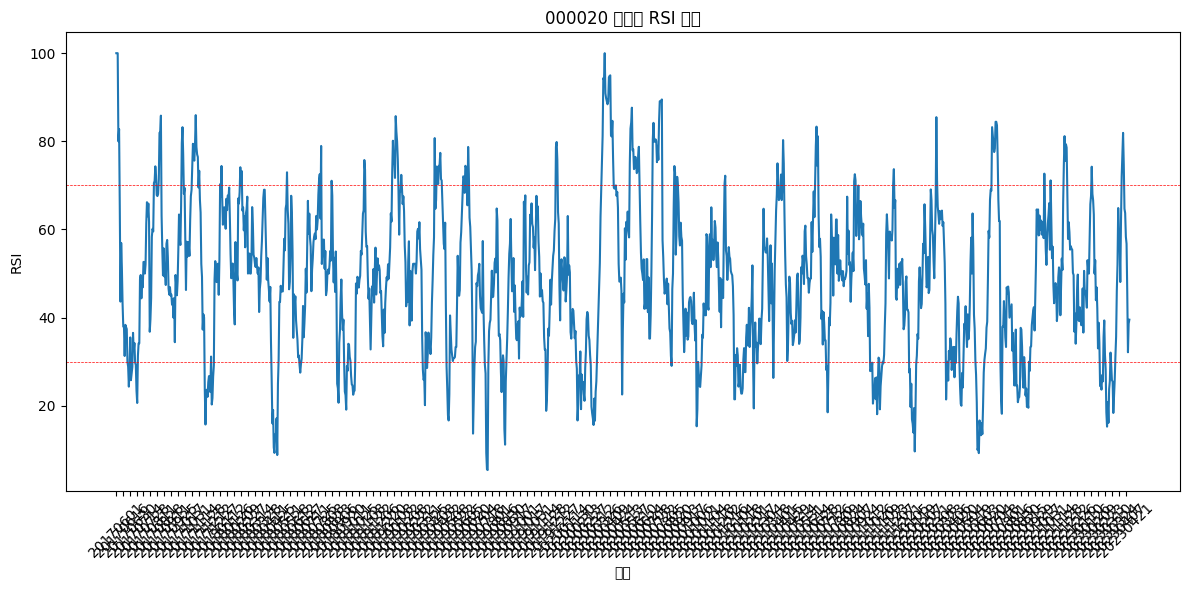

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# 선택할 종목 코드
selected_stock_code = "000020"

# 특정 종목 코드에 대한 RSI 값 추출
selected_rsi_df = df_rsi.filter(df_rsi.stock_code == selected_stock_code)
dates = selected_rsi_df.select("날짜").rdd.flatMap(lambda x: x).collect()
rsi_values = selected_rsi_df.select("RSI").rdd.flatMap(lambda x: x).collect()

# RSI 차트 그리기
plt.figure(figsize=(12, 6))  # 차트 크기 조정
plt.plot(rsi_values)
plt.ylabel("RSI")
plt.title(f"{selected_stock_code} 종목의 RSI 차트")

# RSI 30 이하와 70 이상인 가로줄 추가
plt.axhline(y=30, color='r', linestyle='--', linewidth=0.5)  # RSI 20 이하 가로줄
plt.axhline(y=70, color='r', linestyle='--', linewidth=0.5)  # RSI 80 이상 가로줄

# x축 설정
x_ticks = np.arange(0, len(dates), 10)  # 10일 주기로 눈금 표시
x_labels = [dates[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45)
plt.xlabel("날짜")

plt.tight_layout()  # 차트 요소들의 간격 조정
plt.show()


In [37]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

# 이동평균선을 계산할 기간 설정
short_term = 5
medium_term = 20
long_term = 60

# 각 기간에 대한 컬럼 이름 설정
short_term_col = f"이동평균_{short_term}일"
medium_term_col = f"이동평균_{medium_term}일"
long_term_col = f"이동평균_{long_term}일"

# 종목(stock_code)별로 윈도우 함수 설정
window = Window.partitionBy("stock_code").orderBy("날짜")

# 각 종목별로 이동평균선 계산하여 새로운 컬럼 추가
df_ma = df_rsi.withColumn(short_term_col, avg("종가").over(window.rowsBetween(-(short_term-1), 0))) 


# 결과 확인
df_ma.show()



+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|close_diff|  gain|  loss|          avg_gain|          avg_loss|               RSI|이동평균_5일|
+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+------------+
|20170601|65679|65679|64815|65593|  4832|    000155|      null|   0.0|   0.0|              null|              null|              null|     65593.0|
|20170602|65506|65506|64901|65160|  2192|    000155|    -433.0|   0.0| 433.0|               0.0|               0.0|             100.0|     65376.5|
|20170605|65160|65247|63951|64037|  4118|    000155|   -1123.0|   0.0|1123.0|               0.0|             216.5|               0.0|     64930.0|
|20170607|64037|64383|63691|64123|  2029|    000155|      86.0|  86.0|   0.0|               0.0| 518.6666666666666|               

In [38]:
from pyspark.sql.functions import lag, lead, col

# local minimum과 local maximum을 구하기 위한 조건식 설정
min_conditions = [(col(f"{col_name}") < lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") < lead(col(f"{col_name}")).over(window))
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum과 local maximum을 구하기 위한 조건식 설정
max_conditions = [(col(f"{col_name}") > lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") > lead(col(f"{col_name}")).over(window))
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum과 local maximum을 나타내는 열 추가
df_extrema = df_ma.withColumn("Local_Minimum_5일", when(min_conditions[0], col(short_term_col)).otherwise(None)) \
                  .withColumn("Local_Maximum_5일", when(max_conditions[0], col(short_term_col)).otherwise(None)) 

# 결과 확인
df_extrema.show()



+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+------------+-----------------+-----------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|close_diff|  gain|  loss|          avg_gain|          avg_loss|               RSI|이동평균_5일|Local_Minimum_5일|Local_Maximum_5일|
+--------+-----+-----+-----+-----+------+----------+----------+------+------+------------------+------------------+------------------+------------+-----------------+-----------------+
|20170601|65679|65679|64815|65593|  4832|    000155|      null|   0.0|   0.0|              null|              null|              null|     65593.0|             null|             null|
|20170602|65506|65506|64901|65160|  2192|    000155|    -433.0|   0.0| 433.0|               0.0|               0.0|             100.0|     65376.5|             null|             null|
|20170605|65160|65247|63951|64037|  4118|    000155|   -1123.0|   0.0|1123.0|               0.0|    

In [39]:
columns_to_drop = ["close_diff","gain","loss","avg_gain","avg_loss"]
df_extrema = df_extrema.drop(*columns_to_drop)
df_extrema.show()

+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|               RSI|이동평균_5일|Local_Minimum_5일|Local_Maximum_5일|
+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+
|20170601|65679|65679|64815|65593|  4832|    000155|              null|     65593.0|             null|             null|
|20170602|65506|65506|64901|65160|  2192|    000155|             100.0|     65376.5|             null|             null|
|20170605|65160|65247|63951|64037|  4118|    000155|               0.0|     64930.0|             null|             null|
|20170607|64037|64383|63691|64123|  2029|    000155|               0.0|    64728.25|             null|             null|
|20170608|64037|64037|63086|63605|  9028|    000155| 5.237515225334957|     64503.6|             null|             null|
|20170609|63346|65852|63086|65593| 13546|    000155|

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPytho

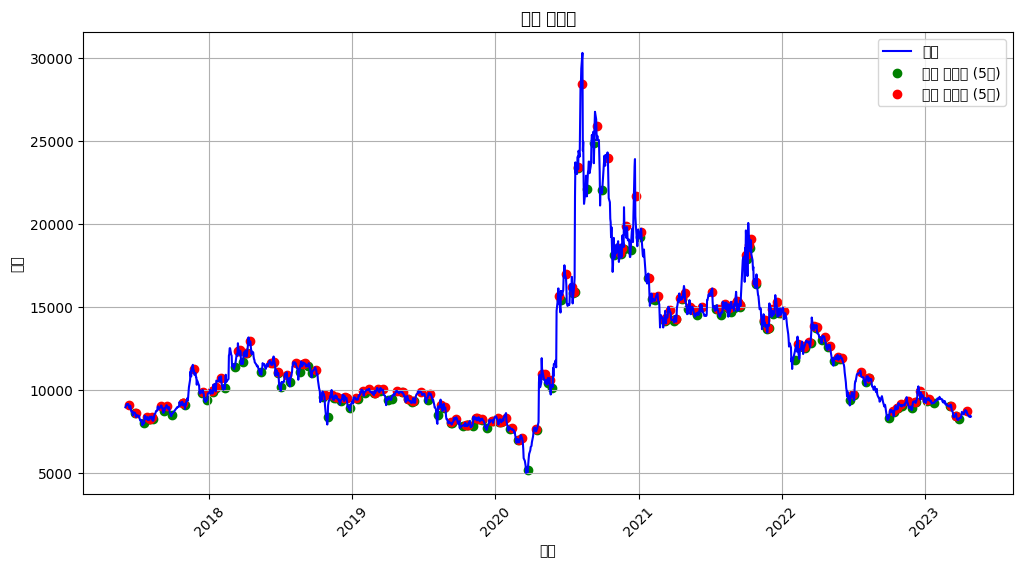

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 데이터 프레임을 판다스 DataFrame으로 변환
df_pd = df_extrema.filter(df_extrema.stock_code == "000020").select("날짜", "종가", "Local_Minimum_5일", "Local_Maximum_5일").toPandas()

# 날짜 형식 변환
df_pd['날짜'] = pd.to_datetime(df_pd['날짜'], format='%Y%m%d')

import numpy as np

# 비어있는 날짜에 NaN 할당
df_pd['종가'] = df_pd['종가'].astype(float)  # 종가 열의 데이터 타입을 float으로 변환
df_pd['종가'] = df_pd['종가'].replace(0, np.nan)  # 종가 열에서 0 값을 NaN으로 대체

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_pd['날짜'], df_pd['종가'], label='종가', color='blue')
plt.scatter(df_pd['날짜'], df_pd['Local_Minimum_5일'], marker='o', color='green', label='로컬 최소값 (5일)')
plt.scatter(df_pd['날짜'], df_pd['Local_Maximum_5일'], marker='o', color='red', label='로컬 최대값 (5일)')
plt.xticks(rotation=45)
plt.xlabel('날짜')
plt.ylabel('종가')
plt.title('종가 그래프')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
from pyspark.sql.functions import lag, lead, col

# local maximum을 구하는 조건식 설정
conditions = [(col(f"{col_name}") > lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") > lead(col(f"{col_name}")).over(window)) &
              (col("RSI") >= 70)
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local maximum을 나타내는 열 추가
df_extrema = df_extrema.withColumn("Local_Maximum_5일_RSI70", when(conditions[0], col(short_term_col)).otherwise(None)) 

# 결과 확인
df_extrema.show()

+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+-----------------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|               RSI|이동평균_5일|Local_Minimum_5일|Local_Maximum_5일|Local_Maximum_5일_RSI70|
+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+-----------------------+
|20170601|65679|65679|64815|65593|  4832|    000155|              null|     65593.0|             null|             null|                   null|
|20170602|65506|65506|64901|65160|  2192|    000155|             100.0|     65376.5|             null|             null|                   null|
|20170605|65160|65247|63951|64037|  4118|    000155|               0.0|     64930.0|             null|             null|                   null|
|20170607|64037|64383|63691|64123|  2029|    000155|               0.0|    64728.25|             null|             null|                   null|
|20170

In [42]:
from pyspark.sql.functions import lag, lead, col

# local minimum을 구하는 조건식 설정
conditions = [(col(f"{col_name}") < lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") < lead(col(f"{col_name}")).over(window)) &
              (col("RSI") <= 30)
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum을 나타내는 열 추가
df_extrema = df_extrema.withColumn("Local_Minimum_5일_RSI30", when(conditions[0], col(short_term_col)).otherwise(None))

# 결과 확인
df_extrema.show()

+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+-----------------------+-----------------------+
|    날짜| 시가| 고가| 저가| 종가|거래량|stock_code|               RSI|이동평균_5일|Local_Minimum_5일|Local_Maximum_5일|Local_Maximum_5일_RSI70|Local_Minimum_5일_RSI30|
+--------+-----+-----+-----+-----+------+----------+------------------+------------+-----------------+-----------------+-----------------------+-----------------------+
|20170601|65679|65679|64815|65593|  4832|    000155|              null|     65593.0|             null|             null|                   null|                   null|
|20170602|65506|65506|64901|65160|  2192|    000155|             100.0|     65376.5|             null|             null|                   null|                   null|
|20170605|65160|65247|63951|64037|  4118|    000155|               0.0|     64930.0|             null|             null|                   null|                   null|
|2017060

In [43]:
columns_to_drop = ["Local_Minimum_5일","Local_Maximum_5일"]
df_extrema = df_extrema.drop(*columns_to_drop)


In [44]:
from pyspark.sql.functions import expr

# 한달 후 상승이 1인 값의 개수 구하기
df_extrema.createOrReplaceTempView("extrema_table")

query = """
SELECT stock_code, COUNT(*) AS `Local_min`
FROM extrema_table
WHERE `Local_Minimum_5일_RSI30` IS NOT NULL
GROUP BY stock_code
"""

result = spark.sql(query)

# 결과 확인
result.show()

+----------+---------+
|stock_code|Local_min|
+----------+---------+
|    000020|       24|
|    000155|       29|
|    000215|       20|
|    000220|       20|
|    000300|       22|
|    000430|       17|
|    000910|       24|
|    001685|       11|
|    001750|       23|
|    002410|       28|
|    002630|       30|
|    003060|       30|
|    003230|       17|
|    003520|       28|
|    003780|       21|
|    003850|       27|
|    004090|       23|
|    004170|       22|
|    004560|       22|
|    004710|       32|
+----------+---------+
only showing top 20 rows



In [45]:
from pyspark.sql.functions import sum

# 전체 값을 더한 결과 구하기
total = result.agg(sum("Local_min").alias("전체_합"))

# 결과 확인
total.show()

# 1291 - 일주일
# 45725 - 두개다
# 널값이 아닌거 22155
# 필터링 하니까 1551개 
# 다시 수정하니까 6938개


+-------+
|전체_합|
+-------+
|  22155|
+-------+



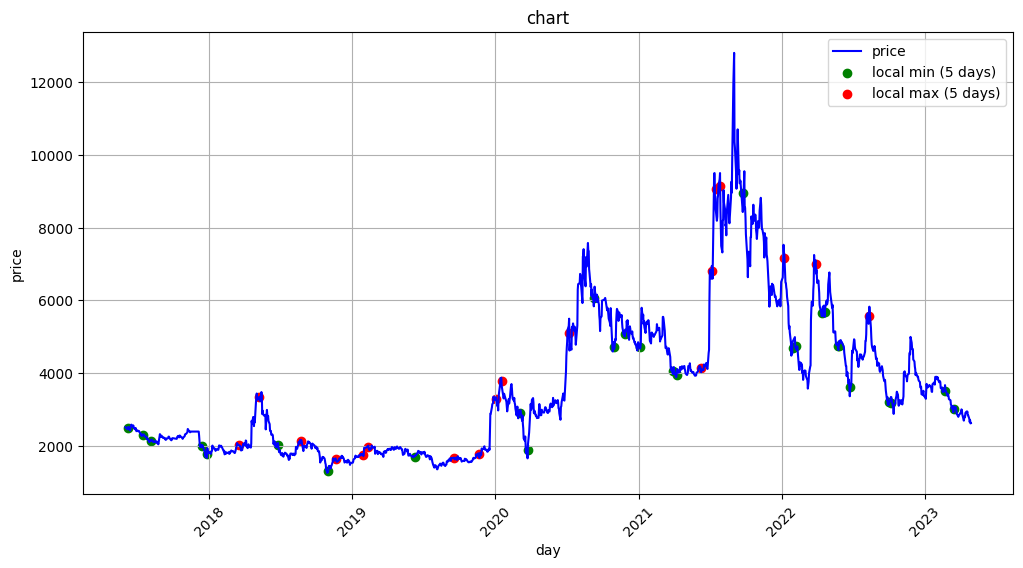

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 데이터 프레임을 판다스 DataFrame으로 변환
df_pd = df_extrema.filter(df_extrema.stock_code == "002410").select("날짜", "종가", "Local_Minimum_5일_RSI30", "Local_Maximum_5일_RSI70").toPandas()

# 날짜 형식 변환
df_pd['날짜'] = pd.to_datetime(df_pd['날짜'], format='%Y%m%d')

import numpy as np

# 비어있는 날짜에 NaN 할당
df_pd['종가'] = df_pd['종가'].astype(float)  # 종가 열의 데이터 타입을 float으로 변환
df_pd['종가'] = df_pd['종가'].replace(0, np.nan)  # 종가 열에서 0 값을 NaN으로 대체

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_pd['날짜'], df_pd['종가'], label='price', color='blue')
plt.scatter(df_pd['날짜'], df_pd['Local_Minimum_5일_RSI30'], marker='o', color='green', label='local min (5 days)')
plt.scatter(df_pd['날짜'], df_pd['Local_Maximum_5일_RSI70'], marker='o', color='red', label='local max (5 days)')
plt.xticks(rotation=45)
plt.xlabel('day')
plt.ylabel('price')
plt.title('chart')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# df = spark.read.option("header", "true").option("encoding", "cp949").csv("hdfs://192.168.219.121:9000/stock/*.csv")
save_path = "hdfs://192.168.219.121:9000/stock_processed/stock_df_processed.parquet"

df_extrema.write.parquet(save_path)

In [48]:
spark.stop()

23/05/31 23:10:27 WARN ExecutorPodsWatchSnapshotSource: Kubernetes client has been closed.
